<a href="https://colab.research.google.com/github/ProjetsPlusIA/deep-image-prior/blob/master/inpainting_kate_peppersv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 13.01 MiB/s, done.
Resolving deltas: 100% (155/155), done.


# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [3]:
## Fig 6
#img_path  = 'data/inpainting/vase.png'
#mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
img_path  = 'data/inpainting/kate.png'
mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

# Load mask

In [4]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)



### Center crop

In [5]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)



### Visualize

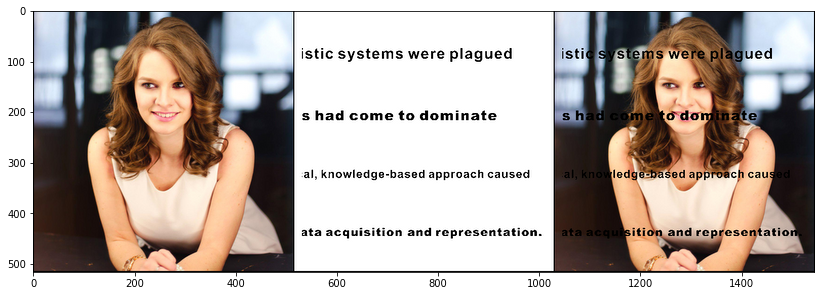

In [6]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Setup

In [7]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [8]:
# Same params and net as in super-resolution and denoising
INPUT = 'noise'
param_noise = False
show_every = 50
figsize = 5
input_depth = 32

net = skip(input_depth, img_np.shape[0], 
          num_channels_down = [128] * 5,
          num_channels_up =   [128] * 5,
          num_channels_skip =    [128] * 5,  
          filter_size_up = 3, filter_size_down = 3, 
          upsample_mode='nearest', filter_skip_size=1,
          need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [9]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 3002627


In [10]:
import matplotlib.pyplot as plt

def scatter_plot(x,y,param):

  plt.scatter(x,y)

  plt.title('La perte en fonction de ' + param)
  plt.xlabel(param)
  plt.ylabel('La fonction perte (Loss)')
  plt.show()

# Main loop

LR: 0.005000
num_iter: 6001
reg_noise_std: 0.030000
Starting optimization with ADAM
LR: 0.010000
num_iter: 6001
reg_noise_std: 0.030000
Starting optimization with ADAM
LR: 0.020000
num_iter: 6001
reg_noise_std: 0.030000
Starting optimization with ADAM


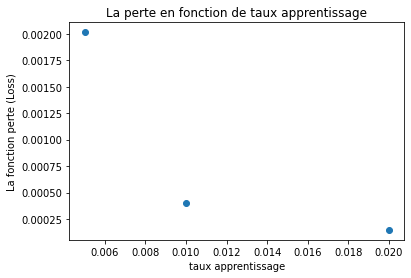

LR: 0.020000
num_iter: 6001
reg_noise_std: 0.030000
Starting optimization with ADAM


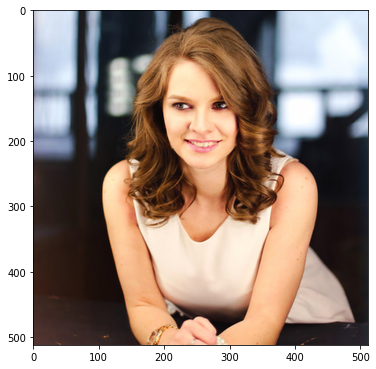

LR: 0.020000
num_iter: 6001
reg_noise_std: 0.030000
Starting optimization with ADAM


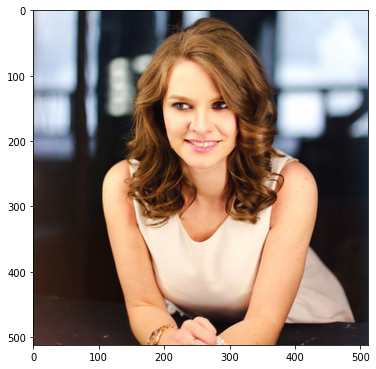

LR: 0.020000
num_iter: 6001
reg_noise_std: 0.030000
Starting optimization with ADAM


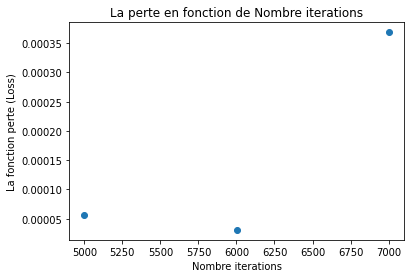

LR: 0.020000
num_iter: 6001
reg_noise_std: 0.030000
Starting optimization with ADAM
LR: 0.020000
num_iter: 6001
reg_noise_std: 0.030000
Starting optimization with ADAM
LR: 0.020000
num_iter: 6001
reg_noise_std: 0.030000
Starting optimization with ADAM


KeyboardInterrupt: ignored

In [11]:
import numpy as np
default_LR = 0.01 
default_num_iter = 6001
default_reg_noise_std = 0.03

i = 0
loss_storage = []
net_input_saved = None
noise = None
reg_noise_std = None
num_iter = 0

def closure():   
    global i
    global loss_storage
    global net_input_saved
    global noise
    global reg_noise_std

    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    loss_storage.append(total_loss.item())
    total_loss.backward()
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
      
    if PLOT and i == (num_iter - 1):
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1
    return total_loss

def main_loop(LR_param, num_iter_param, reg_noise_std_param):
  global i
  global loss_storage
  global net_input_saved
  global noise
  global reg_noise_std

  LR = LR_param
  num_iter = num_iter_param
  reg_noise_std = reg_noise_std_param

  print ('LR: %f' % LR)
  print ('num_iter: %d' % num_iter)
  print ('reg_noise_std: %f' % reg_noise_std)

  loss_storage = []
  i = 0
  net_input_saved = net_input.detach().clone()
  noise = net_input.detach().clone()
  p = get_params(OPT_OVER, net, net_input)
  optimize(OPTIMIZER, p, closure, LR, num_iter)
  #print(loss_storage)

  return np.mean(loss_storage)

LR_values = [0.005, 0.01, 0.02]
num_iter_values = [5001, 6001, 7001]
reg_noise_std_values = [0.02, 0.03, 0.04]

loss_means = []
for LR in LR_values:
  loss_means.append(main_loop(LR, default_num_iter, default_reg_noise_std))
scatter_plot(LR_values,loss_means,'taux apprentissage')

loss_means = []  
for num_iter in num_iter_values:
  loss_means.append(main_loop(LR, default_num_iter, default_reg_noise_std))
scatter_plot(num_iter_values,loss_means,'Nombre iterations')

loss_means = []
for reg_noise_std in reg_noise_std_values:
  loss_means.append(main_loop(LR, default_num_iter, default_reg_noise_std))
scatter_plot(reg_noise_std_values,loss_means,'Ecart type du bruit')


In [ ]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);